# SeismoStats: How To
<div class="alert alert-block alert-info">

#### In this notebook we will show how to:

<ol>
    <li> Make a catalog object
    <ol>
        <li> by downloading it
        <li> by converting a csv file
    </ol>
    <li>Plot the seismicity</li>
    <li>Analyze the FMD</li>
    <ol>
         <li>Plot the FMD</li> 
        <li>Estimate the magnitude of completeness</li> 
        <li>Estimate b-values</li> 
    </ol>
    <li>Generate synthetic magnitudes</li>
    <li>Bin magnitudes</li>
</ol>

</div>

## 0. Import general packages

In [18]:
#%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## 1. Make a catalog object

<div class="alert alert-block alert-warning">
<font color=#208de2>     
The catalog object is a dataframe, with some additional methods and attributes.
The columns are:

|column header |type | importance|
|:-|:-|:-|
|latitude |float |required|
|longitude |float |required|
|depth| float| required|
|mag_type| string| optional|
|magnitude| float| required| 
|time| pandas timestamp| required|
|event_type| string| optional|
</font>
</div>

### 1.1 Download catalog

In [19]:
from seismostats import FDSNWSEventClient

<font color=#208de2> Start date and end date have to be defined as a datetime. In case something does not work out, the link to retrieve it manually is given back. </font>

In [20]:
start_time = pd.to_datetime('2024/01/01')
end_time = pd.to_datetime('2025/01/01')

min_longitude = 5
max_longitude = 11
min_latitude = 45
max_latitude = 48

min_magnitude = 0.5
url = 'http://eida.ethz.ch/fdsnws/event/1/query'
client = FDSNWSEventClient(url)
cat = client.get_events(
    start_time=start_time,
    end_time=end_time,
    min_magnitude=min_magnitude,
    min_longitude=min_longitude,
    max_longitude=max_longitude,
    min_latitude=min_latitude,
    max_latitude=max_latitude)

<font color=#208de2> The output is a catalog object</font>

In [21]:
cat.tail()

,event_type,time,latitude,longitude,depth,evaluationmode,magnitude,magnitude_type,magnitude_MLhc
2458,earthquake,2024-01-02 03:54:53.285746,45.869203,6.985509,6000.976562,manual,0.916012,MLhc,0.9160119489
2459,earthquake,2024-01-01 03:50:58.819682,46.854600,10.084163,229.492188,manual,1.411941,MLhc,1.411940589
2460,earthquake,2024-01-01 03:30:28.449568,45.878719,7.022020,6474.609375,manual,0.593754,MLhc,0.5937540993
2461,earthquake,2024-01-01 03:30:28.469196,45.878310,7.022026,6220.703125,manual,0.674713,MLhc,0.674713413
2462,earthquake,2024-01-01 02:39:21.385390,45.865622,6.997327,7802.734375,manual,0.606296,MLhc,0.6062956275


## 2. Seismicity Plots

<div class="alert alert-block alert-warning">
<font color=#208de2>     
We have three basic plots of the seismicity

<ol>
<li>Seismicity in space</li>
<li>Cumulative count</li> 
<li>Magnitudes in time</li> 
</ol>

</font>
</div>

### 2.1. Plot in space

<font color=#208de2>
It is possible to choose the resolutions 10, 50 and 110. Optionally you can choose the color scheme and the country of which you want to see the borders. For large areas/countries, the plotting can take some time. Finally, it is also possible to chose the color of the dots.
</font>


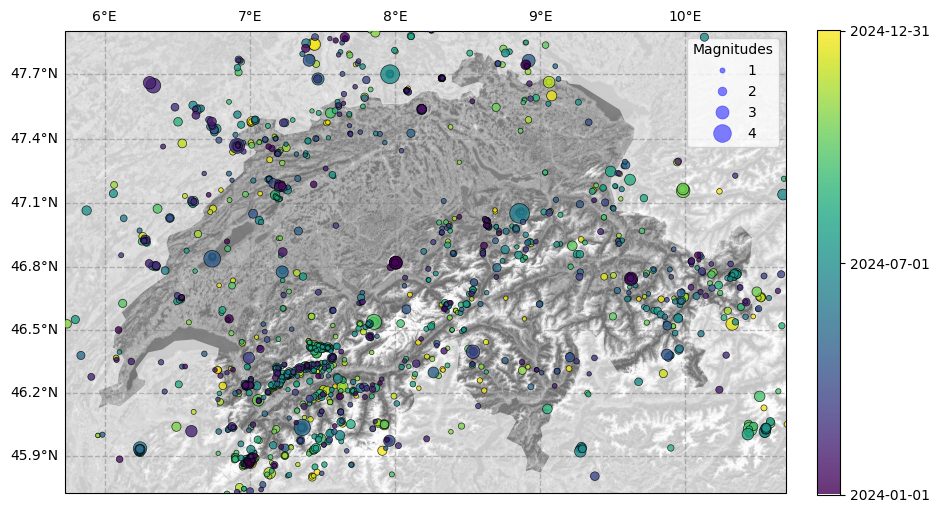

In [47]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Convert to Matplotlib date numbers
times_num = mdates.date2num(cat.time)

fig = plt.figure(figsize=(10, 10), linewidth=1)

ax = cat.plot_in_space(
    resolution='10m',
    include_map=True,
    country='Switzerland',
    color_dots=times_num,
    color_map='Greys_r',
    dot_labels=[1, 2, 3, 4]
)

# Add colorbar
cbar = plt.colorbar(ax.collections[1], ax=ax, orientation='vertical', fraction=0.03, pad=0.04)

# Add dates to colorbar
date_ticks = ["2024-01-01", "2024-07-01", "2024-12-31"]
date_ticks_num = mdates.date2num(date_ticks)
cbar.set_ticks(date_ticks_num)
cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.show()


<font color=#208de2>
You can also choose the interpolation power and the size of the smallest and largest dot. 
</font>


/Users/aron/polybox/Projects/SeismoStats/env/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1692: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  result = super().scatter(*args, **kwargs)


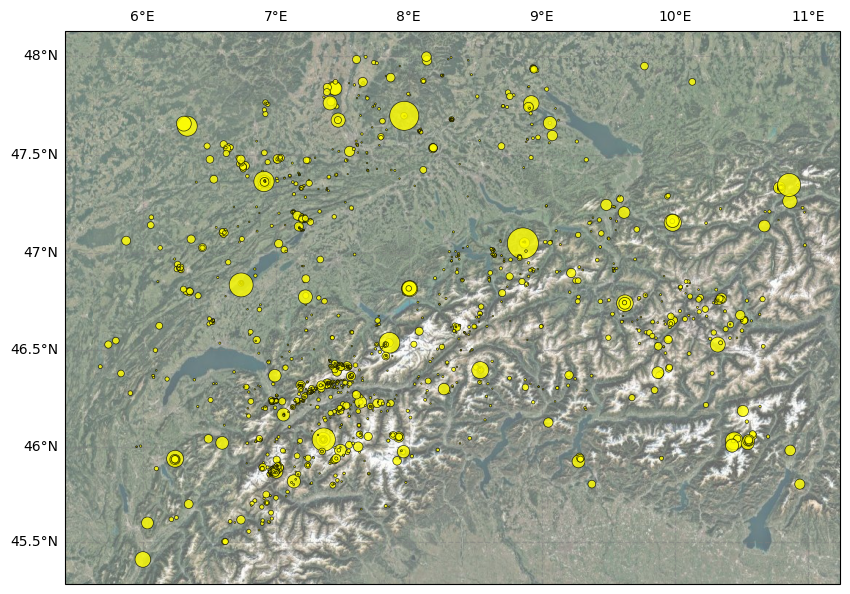

In [49]:
fig = plt.figure(figsize=(10, 10), linewidth=1)    
ax = cat.plot_in_space(
    resolution='10m',
    include_map=True,
    dot_smallest=1,
    dot_largest=500,
    dot_interpolation_power=3,
    dot_labels=None,
    color_dots = 'yellow')

<font color=#208de2>
The default is that the map is not included.
</font>

/Users/aron/polybox/Projects/SeismoStats/env/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1692: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  result = super().scatter(*args, **kwargs)


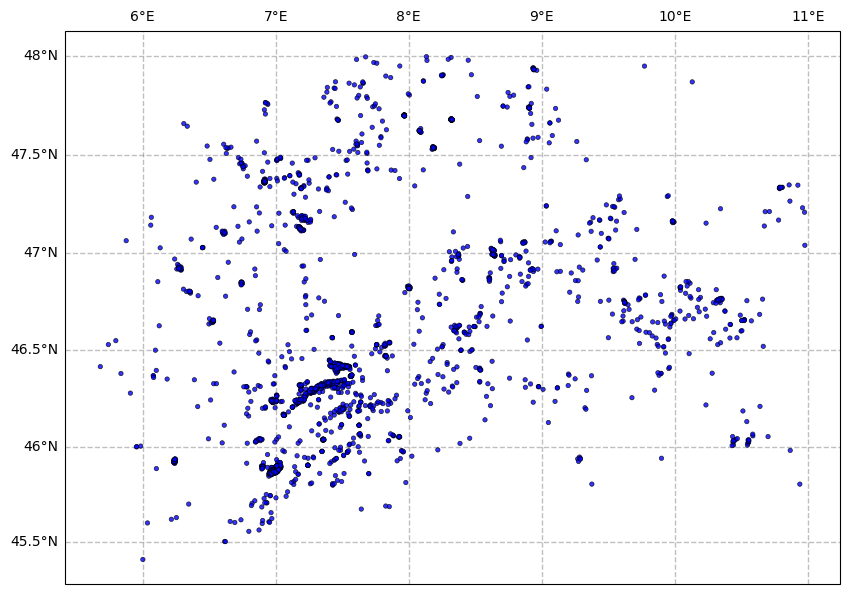

In [50]:
fig = plt.figure(figsize=(10, 10), linewidth=1)    
ax = cat.plot_in_space(
    dot_smallest=0.1,
    dot_largest=10,
    dot_interpolation_power=0,
    dot_labels=False)

### 2.2. Plot in time

[0.5 1.5 2.5 3.5]
(4,)
0.5






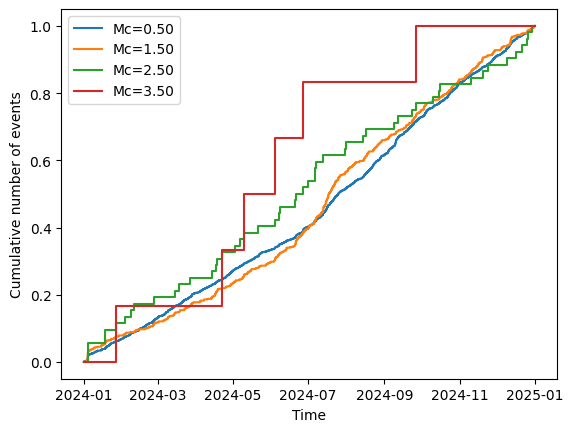

In [51]:
ax = cat.plot_cum_count(mcs=np.arange(0.5, 4.0, 1), delta_m=0.1)

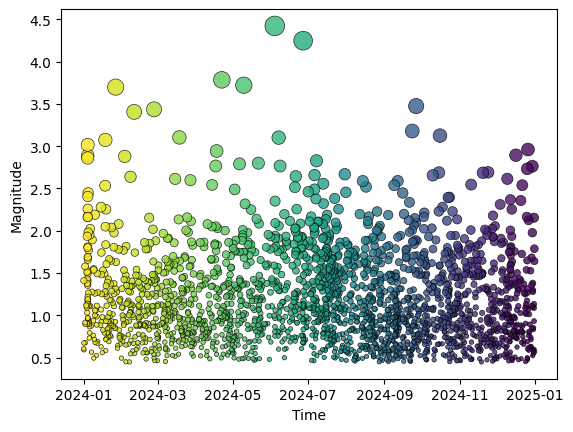

In [52]:
ax = cat.plot_mags_in_time(color_dots=np.arange(len(cat)))

## 3. analysze the FMD

### 3.1 Plot magnitude distributions

In [53]:
# bin the magnitudes (if the binning of the catalog is known, one can just set it instead with e.g. cat.delta_m = 0.01)
cat.bin_magnitudes(delta_m=0.01, inplace=True)

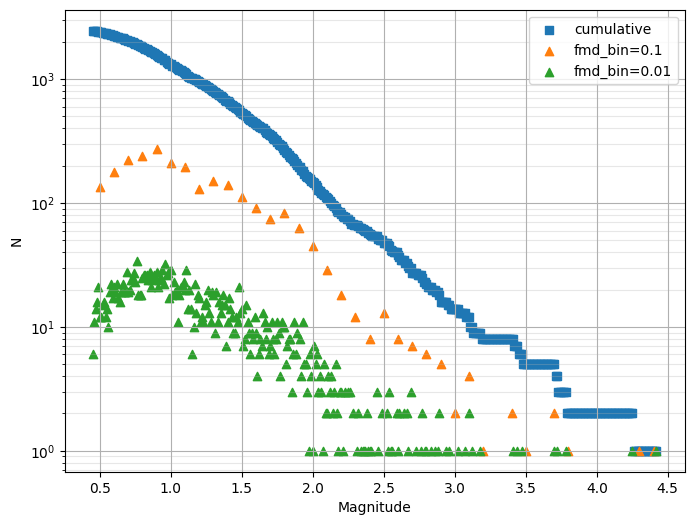

In [54]:
ax = plt.subplots(figsize=(8, 6))[1]

cat.plot_cum_fmd(ax=ax)
cat.plot_fmd(fmd_bin=0.1, ax=ax, grid=True, label='fmd_bin=0.1')
cat.plot_fmd(fmd_bin=0.01, ax=ax, grid=True, label='fmd_bin=0.01')


plt.show()

### 3.2 Estimate completeness magnitude

In [55]:
# estimate b-value by stability
mc_stab, _ = cat.estimate_mc_b_stability(stop_when_passed=True)
# the b-value is saved within the catalog
cat.mc

return_vals: {'best_b_value': np.float64(1.065564675141553), 'mcs_tested': [0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1, 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3, 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4, 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48], 'b_values_tested': [np.float64(0.6146927017570365), np.float64(0.6219881621782115), np.float64(0.6281801117926072), np.float64(0.6337248805802517), np.float64(0.6388470811210967), np.float64(0.6427072915805332), np.float64(0.6490685284765713), np.float64(0.6555731993571426), np.float64(0.6613777867905428), n

/Users/aron/polybox/Projects/SeismoStats/env/lib/python3.12/site-packages/seismostats/analysis/bvalue/base.py:119: UserWarning: No magnitudes in the lowest magnitude bin are present.Check if mc is chosen correctly.
  warnings.warn(


np.float64(1.48)

In [56]:
# You have to chose a delta_m here. This is basicallhy the binning that is used for the maxc method,
# and might be different from the binning of the catalog. Originally, 0.1 was used, but the optimal
# value depends on the data. The best way is to plot_fmd and use the delta_m that makes the most sense for the user.
mc_maxc, _= cat.estimate_mc_maxc(fmd_bin=0.1)
# now, the mc is set to the one that was estimated by the maxc method.
cat.mc

np.float64(1.1)

This method takes longer, especially when the magnitude sample is large.

If Mc is known to be larger than a certain value, giving the Mc values that should be tested as an input can make the Mc estimation faster.

In [62]:
mc_kstest, dict = cat.estimate_mc_ks(
   mcs_test=np.arange(1.0, 3.0, 0.1),
    p_value_pass=0.1,
) 

print(f"First Mc to pass the KS test: {mc_kstest:.2f}")
print(f"Associated beta value: {dict['best_b_value']:.2f}")

First Mc to pass the KS test: 1.60
Associated beta value: 1.10


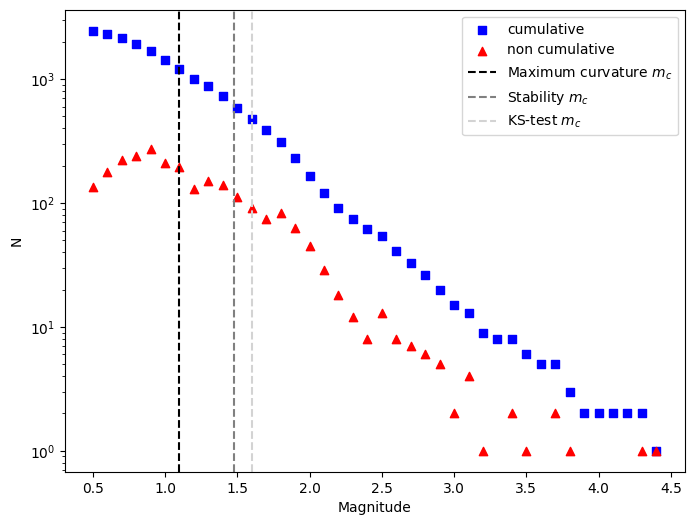

In [65]:
ax = plt.subplots(figsize=(8, 6))[1]

cat.plot_cum_fmd(fmd_bin=0.1, ax=ax, color='blue')
cat.plot_fmd(fmd_bin=0.1, ax=ax, color='red')

plt.axvline(mc_maxc, color='black', linestyle='--', label='Maximum curvature $m_c$')
plt.axvline(mc_stab, color='grey', linestyle='--', label='Stability $m_c$')
plt.axvline(mc_kstest, color='lightgrey', linestyle='--', label='KS-test $m_c$')

plt.legend()
plt.show()

### 3.3 Estimate the b-value

### standard b-value estimation

In [66]:
print("The mc in the catalog method is set to the one that was estimated")
print("by the KS test, because it was the one that was applied latest.")
print("This completeness is going to be used for the b-value estimation.")

b_estimator = cat.estimate_b()
cat.b_value

The mc in the catalog method is set to the one that was estimated
by the KS test, because it was the one that was applied latest.
This completeness is going to be used for the b-value estimation.


np.float64(1.0960854215557083)

In [67]:
# the b-estimator that was given back above contains more information on the b-value estimation
print('b-value', b_estimator.b_value)
print('standard deviation', b_estimator.std)
print('number of events used', b_estimator.n)

b-value 1.0960854215557083
standard deviation 0.05431716016666937
number of events used 434


<Axes: xlabel='Magnitude', ylabel='N'>

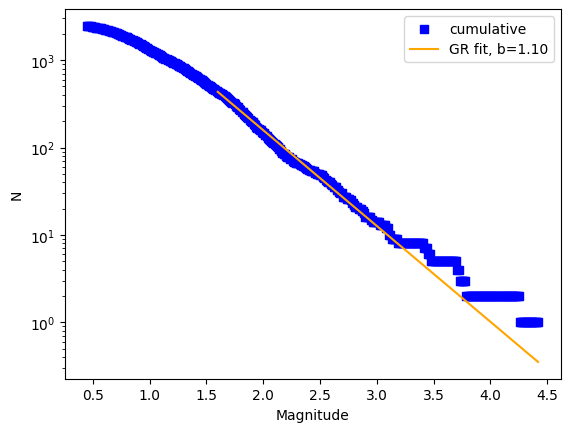

In [70]:
cat.plot_cum_fmd(color='blue', color_line = 'orange')

### using b-positive

In [71]:
from seismostats.analysis import BPositiveBValueEstimator
b_estimator = cat.estimate_b(method =BPositiveBValueEstimator)
cat.b_value

np.float64(1.1254066055974445)

<font color=#208de2> We can also plot the b-value for different mc: </font>

<Axes: xlabel='Completeness magnitude $m_c$', ylabel='b-value'>

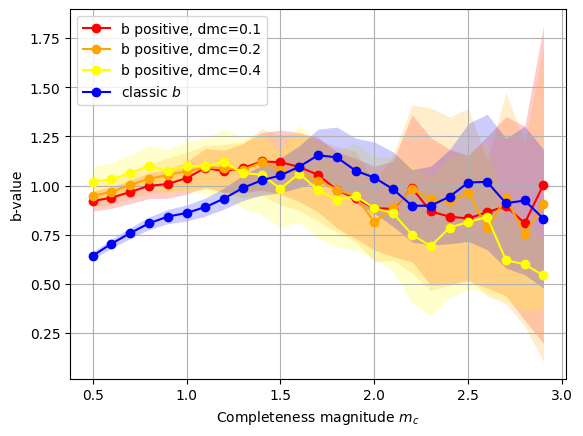

In [72]:
from seismostats.analysis import ClassicBValueEstimator, BPositiveBValueEstimator

mcs = np.arange(0.5, 3, 0.1)
ax = cat.plot_mc_vs_b(mcs, b_method=BPositiveBValueEstimator, dmc=0.1, color='red', label='b positive, dmc=0.1')
cat.plot_mc_vs_b(mcs, b_method=BPositiveBValueEstimator, dmc=0.2, ax=ax,  color='orange', label='b positive, dmc=0.2')
cat.plot_mc_vs_b(mcs, b_method=BPositiveBValueEstimator, dmc=0.4, ax=ax,  color='yellow', label='b positive, dmc=0.4')

cat.plot_mc_vs_b(mcs, b_method=ClassicBValueEstimator, ax =ax, color='blue', label='classic $b$')

### 3.4 Check if the b-value changes significantly

<font color=#208de2> Once we picked a fitting completeness, we might also want to see how the b-value changes with time (or along any other dimension). Unfortunately, this one is not yet implemented for the catalog class, so we have to use the original function </font>

In [73]:
from seismostats.analysis import b_significant_1D
from seismostats.plots import plot_b_series_constant_nm, plot_b_significant_1D
from seismostats.analysis import BPositiveBValueEstimator

In [74]:
mc = 1
delta_m = cat.delta_m

times = cat.time
mags = cat.magnitude

/Users/aron/polybox/Projects/SeismoStats/env/lib/python3.12/site-packages/seismostats/analysis/bvalue/base.py:119: UserWarning: No magnitudes in the lowest magnitude bin are present.Check if mc is chosen correctly.
  warnings.warn(


Text(0.5, 0, 'Time')

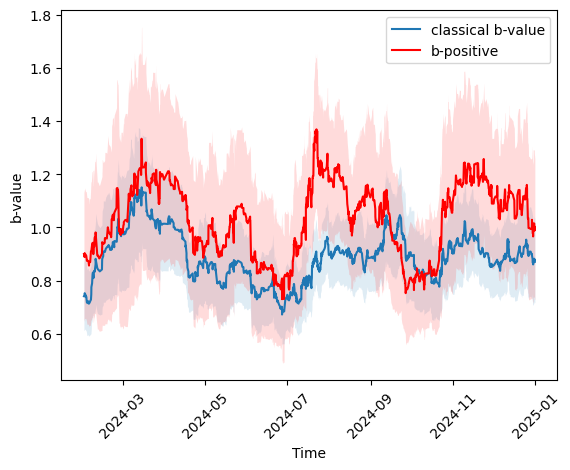

In [75]:
n_m = 100 # number of magnitudes taken per estimate in the running window

idx = mags >= 0
ax = plot_b_series_constant_nm(mags, delta_m, mc, times, n_m=n_m,x_variable=times, color='#1f77b4', plot_technique='right', label='classical b-value')

ax = plot_b_series_constant_nm(mags[idx], delta_m, mc, times[idx], n_m=n_m,x_variable=times[idx], color='red', plot_technique='right', label='b-positive', ax=ax, b_method=BPositiveBValueEstimator)

_ = plt.xticks(rotation=45)
ax.set_xlabel('Time')

<font color=#208de2> Looking at the time-series above, one could be interested if the variation of the b-value is larger than what one would expect just from random fluctuation of the estimate. In other words, we want to know if we can reject the null-hypothesis that the true b-value is constant. For this, we can apply the method of Mirwald et. al., 2024.

For this, we estimate the mean autocorrelation (MAC). The MAC can then be used to estimate a p-value. If the p-value is smaller than a threshold (which we have to choose, often 0.05 is used), then we can reject the null-hypothesis, and we are justified to believe that the b-vlue is in fact changing.  </font>

In [76]:
n_m = 100

p, mac, mu_mac, std_mac = b_significant_1D(mags, mc, delta_m, times, n_m)

# b-positive
p, mac, mu_mac, std_mac = b_significant_1D(mags, mc, delta_m, times, n_m, method= BPositiveBValueEstimator)

/Users/aron/polybox/Projects/SeismoStats/env/lib/python3.12/site-packages/seismostats/analysis/b_significant.py:383: UserWarning: The number of subsamples is less than 25. The normality assumption of the autocorrelation might not be valid.
  warnings.warn(


In [77]:
p_threshold = 0.05
print('The p-value of a constant b-value hypothesis is {:.2f}'.format(p))
print('This is significantly larger than our threshold of {:.2f}. Therefore, we cannot reject the null-hypothesis'.format(p_threshold))

The p-value of a constant b-value hypothesis is 0.42
This is significantly larger than our threshold of 0.05. Therefore, we cannot reject the null-hypothesis


<font color=#208de2> We found that the temporal variation was not significant, therefore further interpretation of how the b-value changes with time might not be reasonable to do. But this was specifically using a certain number of magnitudes per estimate. Maybe there is some other scale, where the b-value does change significantly?

We can test this easily by applying the same method with different n_m. </font>

<Axes: xlabel='$n_m$', ylabel='MAC'>

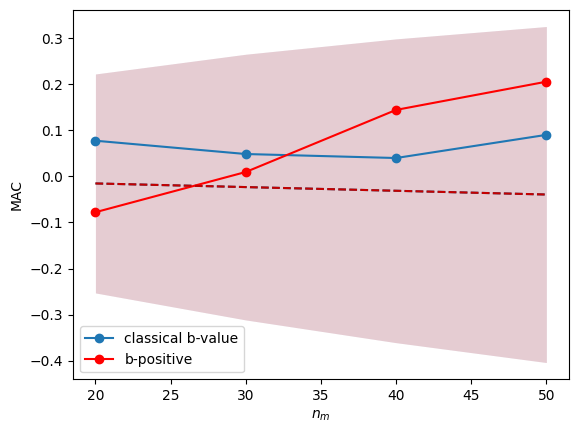

In [78]:
ax = plot_b_significant_1D(
    mags, times, mc, delta_m, x_variable = times, color = '#1f77b4', label='classical b-value')

plot_b_significant_1D(
    mags, times, mc, delta_m, x_variable = times, color = 'red', b_method=BPositiveBValueEstimator, ax = ax, label='b-positive')


<font color=#208de2> We found that in fact, the variation of the b-value is not significant within the scales that we can practically test. </font>

## 4. Generate and bin synthetic earthquakes

<div class="alert alert-block alert-warning">
<font color=#208de2>     
First we need to define the number of earthquakes, the b-value and the completeness magnitude. If binnning is applied, it is important to generate the magnitudes half a bin smaller than the smallest magnitude, otherwise the first bin will contain only half the events. For the b-value, note that beta is defined as the natural logarithm equivalent of the b-value.
</font>
</div>

In [79]:
from seismostats import Catalog
from seismostats.analysis import estimate_b
from seismostats.utils import simulate_magnitudes_binned
from seismostats.plots import plot_cum_fmd
import matplotlib.pyplot as plt

In [80]:
n = 200
b_value = 1.5
delta_m = 0.05
mc = 3
dmc = 0.3

<font color=#208de2> Now we can generate a synthetic magnitude distribution: </font>

In [81]:
mags = simulate_magnitudes_binned(n, b_value, mc, delta_m)
cat = pd.DataFrame({'magnitude': mags})
cat = Catalog(cat)
cat.delta_m = delta_m
cat.mc = mc

<font color=#208de2> Now we can estimate the b-value: </font>

In [82]:
# equivelently, you can use the Catalog method
cat.estimate_b()
print('b-value', cat.b_value)

b-value 1.4999940534348186


<font color=#208de2> We can plot the original and binned magnitudes and their respective b-value estimates now. Note that we choose the bin position to be left in order to align the binned and the original magnitudes. </font>

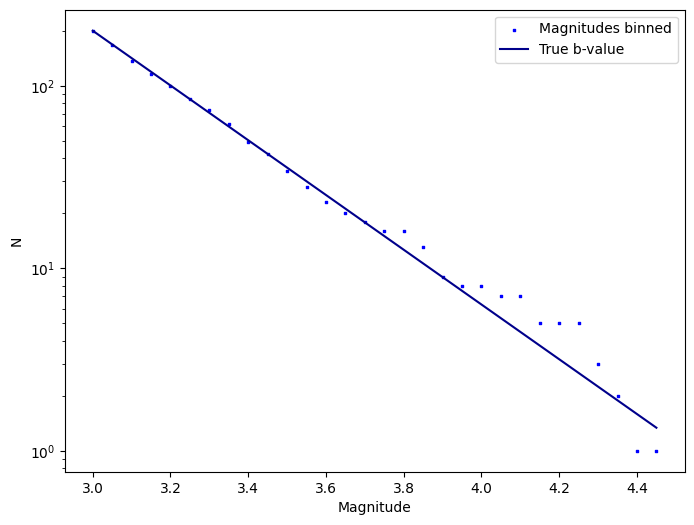

In [90]:
ax = plt.subplots(figsize=(8, 6))[1]

cat.plot_cum_fmd(ax=ax, b_value=b_value,
             color='blue', color_line = 'darkblue', label='Magnitudes binned', label_line = 'True b-value', size=3)

plt.show()